In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

from collections import Counter

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from scipy import sparse

from datetime import date, datetime

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [118]:
# functions required to perform basic transformations
# these transformations can be safely applied to all the data set (inc validation)
# because they only take into consideration the values of the current row

# function to translate gender into 
def get_gender(_input):
    if 'Female' in _input:
        return 'F'
    elif 'Male' in _input:
        return 'M'
    else:
        return 'U'

# function that returns 1 if animal was operated; 0 otherwise
def is_operated(_input):    
    return int(_input.split()[0] in ['Neutered', 'Spayed'])   

# function that normalises age of animal in years
def get_age_in_years(_input):
    age = 0.0
    age_list = _input.split()
    if "year" in age_list[1]:
        age = float(age_list[0])
    elif "month" in age_list[1]:
        age = float(age_list[0]) / 12.0
    elif "week" in age_list[1]:
        age = float(age_list[0]) / 52.0
    else:
        # if less than 1 week, default to 1 week
        age = 1.0 / 52.0
    return round(age, 3)

# Transform ages to categoris as follows:
# 1 = neonatal; 2 = infant; 3 = child; 4 = adolescent; 5 = young_adult; 6 = mature_adult; 7 = old
# These categories are based on rate that animal ages w.r.t. human years and the stages of human development
# https://www.ajdesigner.com/fl_cat_age/cat_age.php; https://pets.webmd.com/dogs/how-to-calculate-your-dogs-age
def get_age_in_labels(_input):
    age_label = 0
    age_list = _input.split()
    age = int(age_list[0])
    if "year" in age_list[1]:
        # 
        options = [4, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7]
        age = age - 1 if age < 11 else 10
        age_label = options[age]        
    elif "month" in age_list[1]:
        options = [2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3]
        age_label = options[age-1]
    elif "week" in age_list[1]:        
        age_label = 1
    else:
        # if less than 1 week, default to 1 week
        age_label = 1
    return age_label

# this function returns purity category: "pure", "mixed", "cross"
# depending on whether breed string features just the animal breed, the word "mix" or a fwd-slash
def get_breed_purity(_input):
    breed_purity = ""
    if "/" in _input:
        breed_purity = "mix"
    elif "Mix" in _input:
        breed_purity = "mix"
    else:
        breed_purity = "pure"
    return breed_purity

# code to determine season from: https://stackoverflow.com/a/28688724
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

def get_hour(now):
    hr = int(now.hour + round(now.minute/60.0))
    return (0 if (hr == 24) else hr)

def get_sine_transformation(value, max_value):
    return np.sin(2 * np.pi * (value / max_value))

def get_cosine_transformation(value, max_value):
    return np.cos(2 * np.pi * (value / max_value))

In [3]:
df = pd.read_csv('train.csv', header=0, sep=",")
# print columns having at least one null entry
print df.isnull().any()
# remove entries where age = 0
df = df[~(df.AgeuponOutcome == '0 years')]

AnimalID          False
Name               True
DateTime          False
OutcomeType       False
OutcomeSubtype     True
AnimalType        False
SexuponOutcome     True
AgeuponOutcome     True
Breed             False
Color             False
dtype: bool


In [261]:
# import training data in pandas dataframe df
df = pd.read_csv('train.csv', header=0, sep=",")

# only 1 case of unknown sex
df[df["SexuponOutcome"].isnull() == True]
# only 18 cases of unknown age
len(df[df["AgeuponOutcome"].isnull() == True])
# remove null cases 

# remove null ages
df = df[~df['AgeuponOutcome'].isnull()]
df = df[~df['SexuponOutcome'].isnull()]
#print df.isnull().any()

# there are 22 cases where Age is 0 years; the distribution of outcomes (compared to the cases where age is known)
# best would be to remove these from the set too
print df[(df.AgeuponOutcome == '0 years')]["OutcomeType"].value_counts()
#df.loc[df.AgeuponOutcome == '0 years', 'AgeuponOutcome'] = "1 week"
df = df[~(df.AgeuponOutcome == '0 years')]

Transfer      19
Euthanasia     2
Died           1
Name: OutcomeType, dtype: int64


In [262]:
df["HasName"] = (~df.loc[:,"Name"].isnull()).apply(lambda x: int(x))
df["IsOperated"] = df["SexuponOutcome"].apply(is_operated)
df["Gender"] = df["SexuponOutcome"].apply(get_gender)
df["AgeInYears"] = df["AgeuponOutcome"].apply(get_age_in_years)
#df["AgeCategory"] = df["AgeuponOutcome"].apply(get_age_in_labels)
df["BreedPurity"] = df["Breed"].apply(get_breed_purity).astype('category')
#df["IsWeekend"] = pd.to_datetime(df.DateTime).apply(lambda x: int(1  if x.weekday() in [5,6] else 0))
#df["Season"] = pd.to_datetime(df.DateTime).apply(get_season)
df["DayOfWeek"] = pd.to_datetime(df.DateTime).apply(lambda x: int(x.weekday()))
#df["MonthOfYear"] = pd.to_datetime(df.DateTime).apply(lambda x: int(x.month))

#df["SinDayOfWeek"] = pd.to_datetime(df.DateTime).apply(lambda x: get_sine_transformation(x.weekday()+1.,7.) ) 
#df["CosDayOfWeek"] = pd.to_datetime(df.DateTime).apply(lambda x: get_cosine_transformation(x.weekday()+1.,7.) ) 
#df["MonthOfYear"] = pd.to_datetime(df.DateTime).apply(lambda x: int(x.month))

df["SinMonth"] = pd.to_datetime(df.DateTime).apply(lambda x: get_sine_transformation(x.month, 12.) ) 
df["CosMonth"] = pd.to_datetime(df.DateTime).apply(lambda x: get_cosine_transformation(x.month, 12.) ) 

# include name frequency column
#names = df.Name[df.Name.isnull() == False]
#names_freq = names.value_counts()#/names.shape[0]

#df["NameFreq"] = 0.
#df.loc[df.HasName==True,"NameFreq"] = df.loc[df.HasName==True,"Name"].apply(lambda x: names_freq[x])

#df['TimeOfDay'] = pd.to_datetime(df.DateTime).apply(get_hour)
# apply sin and cos transforms to time to capture cyclic nature of time
sec_since_midnight = pd.to_datetime(df.DateTime).apply(lambda x: (x.hour * 3600) + (x.minute * 60) )
#df["SinTime"] = np.sin(2 * np.pi * sec_since_midnight / (24*60*60))
#df["CosTime"] = np.cos(2 * np.pi * sec_since_midnight / (24*60*60))
df["SinTime"] = get_sine_transformation(sec_since_midnight, 24*60*60)
df["CosTime"] = get_cosine_transformation(sec_since_midnight, 24*60*60)

df.head()


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,HasName,IsOperated,Gender,AgeInYears,BreedPurity,DayOfWeek,SinMonth,CosMonth,SinTime,CosTime
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1,1,M,1.000,mix,2,0.866025,0.500000,-0.995396,0.095846
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1,1,F,1.000,mix,6,-0.866025,0.500000,-0.190809,-0.981627
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,1,1,M,2.000,mix,5,0.500000,0.866025,-0.121869,-0.992546
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,0,0,M,0.058,mix,4,-0.500000,-0.866025,-0.955020,0.296542
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,0,1,M,2.000,mix,4,-0.500000,0.866025,-0.224951,-0.974370


In [71]:
np.min(df.AgeInYears), np.max(df.AgeInYears)

(0.019, 20.0)

In [ ]:
#iris.groupby("Name").PetalWidth.plot(kind='kde', ax=axs[1])

#df.loc[df.HasName == True, ["NameFreq", "OutcomeType"]].groupby("OutcomeType").NameFreq.plot(kind='kde',figsize=(20,10))
df.loc[:, ["AgeInYears", "OutcomeType"]].groupby("OutcomeType").AgeInYears.plot(kind='kde',figsize=(20,10))
#df.loc[:, ["TimeOfDay", "OutcomeType"]].groupby("OutcomeType").TimeOfDay.plot(kind='kde',figsize=(20,10))
#df.loc[:,['SinTime', 'CosTime']].plot.scatter('SinTime','CosTime').set_aspect('equal');
plt.show()

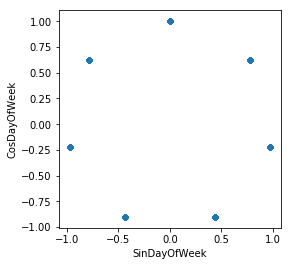

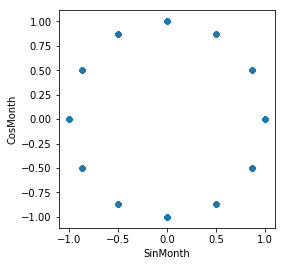

In [145]:
%matplotlib inline
#df.head()
#df.columns
# plot line graph of week day by outcome
#day_of_week = pd.crosstab(df.DayOfWeek, df.OutcomeType,margins=False)
#day_of_week.plot(kind='line', figsize=(10,6))
#pd.crosstab(df.MonthOfYear, df.OutcomeType,margins=False).plot(kind='line', figsize=(10,6))
#pd.crosstab(df.AgeCategory, df.OutcomeType,margins=False).plot(kind='line', figsize=(10,6))
#pd.crosstab(df.TimeOfDay, df.OutcomeType,margins=False).plot(kind='line', figsize=(10,6))
#df.plot.scatter('SinTime','CosTime').set_aspect('equal');
df.plot.scatter('SinDayOfWeek','CosDayOfWeek').set_aspect('equal');
df.plot.scatter('SinMonth','CosMonth').set_aspect('equal');
#plt.show()


In [134]:
df.columns

Index([u'AnimalID', u'Name', u'DateTime', u'OutcomeType', u'OutcomeSubtype',
       u'AnimalType', u'SexuponOutcome', u'AgeuponOutcome', u'Breed', u'Color',
       u'HasName', u'IsOperated', u'Gender', u'AgeInYears', u'BreedPurity',
       u'SinDayOfWeek', u'CosDayOfWeek', u'SinMonth', u'CosMonth', u'SinTime',
       u'CosTime'],
      dtype='object')

In [263]:
print df.columns
# one-hot encode categorical variables
#categorical_cols = ['AnimalType', 'Gender', 'BreedPurity', 'AgeCategory', 'MonthOfYear', 'DayOfWeek','Season']
categorical_cols = ['AnimalType','Gender','BreedPurity','DayOfWeek']
rid_cols = ['AnimalID', 'DateTime', 'OutcomeSubtype','SexuponOutcome','AgeuponOutcome','Breed', 'Color']
#rid_cols = ['AnimalID', 'Name', 'DateTime', 'OutcomeSubtype','SexuponOutcome','AgeuponOutcome','Breed', 'Color','Gender','BreedPurity','MonthOfYear']
df_model = pd.get_dummies(df, columns=categorical_cols, drop_first=True).drop(rid_cols, axis=1)
print df_model.columns

Index([u'AnimalID', u'Name', u'DateTime', u'OutcomeType', u'OutcomeSubtype',
       u'AnimalType', u'SexuponOutcome', u'AgeuponOutcome', u'Breed', u'Color',
       u'HasName', u'IsOperated', u'Gender', u'AgeInYears', u'BreedPurity',
       u'DayOfWeek', u'SinMonth', u'CosMonth', u'SinTime', u'CosTime'],
      dtype='object')
Index([u'Name', u'OutcomeType', u'HasName', u'IsOperated', u'AgeInYears',
       u'SinMonth', u'CosMonth', u'SinTime', u'CosTime', u'AnimalType_Dog',
       u'Gender_M', u'Gender_U', u'BreedPurity_pure', u'DayOfWeek_1',
       u'DayOfWeek_2', u'DayOfWeek_3', u'DayOfWeek_4', u'DayOfWeek_5',
       u'DayOfWeek_6'],
      dtype='object')


In [ ]:
# minmax scaling algorithms
if 'AgeInYears' in expl_variables:    
    age_minmax = MinMaxScaler().fit(X_train.AgeInYears.values.reshape(-1,1))
    X_train.loc[:,"AgeInYears"] = age_minmax.transform(X_train.AgeInYears.values.reshape(-1,1))
    X_valid.loc[:,"AgeInYears"] = age_minmax.transform(X_valid.AgeInYears.values.reshape(-1,1))

    #age_scale = StandardScaler().fit(X_train.AgeInYears.values.reshape(-1,1))
    #X_train.loc[:,"AgeInYears"] = age_scale.transform(X_train.AgeInYears.values.reshape(-1,1))
    #X_valid.loc[:,"AgeInYears"] = age_scale.transform(X_valid.AgeInYears.values.reshape(-1,1))

if 'NameFreq' in expl_variables:    
    name_minmax = MinMaxScaler().fit(X_train.NameFreq.values.reshape(-1,1))
    X_train.loc[:,"NameFreq"] = name_minmax.transform(X_train.NameFreq.values.reshape(-1,1))
    X_valid.loc[:,"NameFreq"] = name_minmax.transform(X_valid.NameFreq.values.reshape(-1,1))

if 'SinTime'in expl_variables:    
    sintime_minmax = MinMaxScaler().fit(X_train.SinTime.values.reshape(-1,1))
    costime_minmax = MinMaxScaler().fit(X_train.CosTime.values.reshape(-1,1))

    X_train.loc[:,"SinTime"] = sintime_minmax.transform(X_train.SinTime.values.reshape(-1,1))
    X_train.loc[:,"CosTime"] = costime_minmax.transform(X_train.CosTime.values.reshape(-1,1))

    X_valid.loc[:,"SinTime"] = sintime_minmax.transform(X_valid.SinTime.values.reshape(-1,1))
    X_valid.loc[:,"CosTime"] = costime_minmax.transform(X_valid.CosTime.values.reshape(-1,1))


In [259]:
def get_freq(names_freq, name):
    freq = 0.
    try:
        freq = names_freq[name]
    except:
        freq = 0.
    return freq
    
def create_name_freq(data, names_freq, drop):
    data.loc[:, "NameFreq"] = 0.
    data.loc[data.HasName==True,"NameFreq"] = data.loc[data.HasName==True,"Name"].apply(lambda x: get_freq(names_freq, x)) 
    if drop == True:
        return data.drop(['Name'], axis=1)    
    return data

In [266]:
#model_columns = ['AnimalType', 'Breed', 'Color', 'OutcomeType']
#df_model = df.loc[:,model_columns]
#df_model.head()
expl_variables = [x for x in df_model.columns if x not in ['OutcomeType']]
X = df_model.loc[:,expl_variables]
y = df_model.loc[:,'OutcomeType']

le = LabelEncoder()
y = le.fit_transform(y)

# stratify test/validation split
# split into train and test
from sklearn.cross_validation import StratifiedKFold
eval_size = 0.1
kf = StratifiedKFold(y, round(1./eval_size))
train_indices, valid_indices = next(iter(kf))

X_train, y_train = X.iloc[train_indices,:], y[train_indices]
X_valid, y_valid = X.iloc[valid_indices,:], y[valid_indices]

# let's include name frequency but avoid leaking names found in the validation set
names = X_train.loc[X_train.Name.isnull() == False, 'Name']
names_freq = names.value_counts()

#X_train.loc[X_train.HasName==True,"NameFreq"] = X_train.loc[X_train.HasName==True,"Name"].apply(lambda x: names_freq[x])
X_train = X_train.pipe(create_name_freq, names_freq, True)
X_valid = X_valid.pipe(create_name_freq, names_freq, True)

expl_variables = [x for x in X_train.columns if x not in ['OutcomeType']]

minmax = MinMaxScaler();
minmax = minmax.fit(X_train)
X_train = minmax.transform(X_train)
X_valid = minmax.transform(X_valid)

#stdsc = StandardScaler()
#X_train = stdsc.fit_transform(X_train)
#X_valid = stdsc.transform(X_valid)

#X_train = X_train.values
#X_valid = X_valid.values

# Check label proportions
from collections import Counter
_foo = Counter(y_train), Counter(y_valid)

print _foo

# confirm that propotion of test outcome is similar to population proportion
print [round(float(_foo[0][x]) / sum(_foo[0].values()),3)   for x in _foo[0]]

# confirm that propotion of train outcome is similar to population proportion
print [round(float(_foo[1][x]) / sum(_foo[1].values()),3)   for x in _foo[1]]

expl_variables

(Counter({0: 9692, 4: 8448, 3: 4306, 2: 1395, 1: 176}), Counter({0: 1077, 4: 939, 3: 479, 2: 156, 1: 20}))
[0.404, 0.007, 0.058, 0.179, 0.352]
[0.403, 0.007, 0.058, 0.179, 0.352]


['HasName',
 'IsOperated',
 'AgeInYears',
 'SinMonth',
 'CosMonth',
 'SinTime',
 'CosTime',
 'AnimalType_Dog',
 'Gender_M',
 'Gender_U',
 'BreedPurity_pure',
 'DayOfWeek_1',
 'DayOfWeek_2',
 'DayOfWeek_3',
 'DayOfWeek_4',
 'DayOfWeek_5',
 'DayOfWeek_6',
 'NameFreq']

In [278]:
np.min(X_train), np.max(X_train)
np.min(X_valid), np.max(X_valid)
#X_train[:5,:]

(0.0, 1.0)

In [ ]:
# concatenate breed and colour
train_breed_colour = list(X_train.apply(lambda x: '%s %s' % (x['Breed'], x['Color']),axis=1))
valid_breed_colour = list(X_valid.apply(lambda x: '%s %s' % (x['Breed'], x['Color']),axis=1))

ctv = CountVectorizer(binary=True, min_df=30, max_df=0.6)
train_breed_colour_matrix = ctv.fit_transform(train_breed_colour)
valid_breed_colour_matrix = ctv.transform(valid_breed_colour)
#print(breed_colour[:2])
#X.head(2)

In [ ]:
def get_top_n_features(count_vector, vectorizer):
    weights = count_vector.toarray().mean(axis=0).ravel().tolist()
    weights_df = pd.DataFrame({'term': vectorizer.get_feature_names(), 'weight':weights})
    print weights_df.sort_values(by='weight', ascending=False).head(20)    

get_top_n_features(train_breed_colour_matrix, ctv)
#len(ctv.get_feature_names())
#train_breed_colour_matrix.toarray().mean(axis=0).ravel()

In [ ]:
len(ctv.get_feature_names())
#print ctv.get_feature_names()
print X_train.head(2)
# 289 features
#train_breed_colour_matrix['chi']
ctv.get_feature_names().index('chihuahua')

X_train2 = (pd.get_dummies(X_train, columns=['AnimalType'], drop_first=True).drop(['Breed', 'Color'], axis = 1)).values
X_train2 = sparse.hstack((sparse.coo_matrix(X_train2), train_breed_colour_matrix))

X_valid2 = (pd.get_dummies(X_valid, columns=['AnimalType'], drop_first=True).drop(['Breed', 'Color'], axis = 1)).values
X_valid2 = sparse.hstack((sparse.coo_matrix(X_valid2), valid_breed_colour_matrix))

    
print train_breed_colour_matrix.shape, X_train2.shape
print valid_breed_colour_matrix.shape, X_valid2.shape


In [ ]:
# attempt multi variate bernoulli with just breed and colour
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X_train2, y_train)

In [ ]:
#clf.score(train_breed_colour_matrix, y_train)
#clf.score(valid_breed_colour_matrix, y_valid)
prediction = clf.predict(X_train2)
print(classification_report(y_train, prediction, target_names=le.classes_))

valid_prediction = clf.predict(X_valid2)
print(classification_report(y_valid, valid_prediction, target_names=le.classes_))

# high recall but low accuracy when attempting to predict return to owner based on just breed tokens

In [ ]:
# attempt to run Truncated SVF on binary vectorizer
svd = TruncatedSVD(n_components=10)
# fit svd decomposer on vectorisation matrix result
X_train_svd = svd.fit_transform(train_breed_colour_matrix)
X_valid_svd = svd.transform(valid_breed_colour_matrix)

In [ ]:
X_train3 = (pd.get_dummies(X_train, columns=['AnimalType'], drop_first=True).drop(['Breed', 'Color'], axis = 1)).values
X_train3 = np.hstack((X_train3, X_train_svd))

X_valid3 = (pd.get_dummies(X_valid, columns=['AnimalType'], drop_first=True).drop(['Breed', 'Color'], axis = 1)).values
X_valid3 = np.hstack((X_valid3, X_valid_svd))


In [ ]:
# plot terms by weight and component
def plot_weighted_terms_by_component(svd, feat_names):
    for compNum in range(0, 10):
        comp = svd.components_[compNum]

        # Sort the weights in the first component, and get the indeces
        indices = np.argsort(comp).tolist()
        #print len(indices)
        # Reverse the indeces, so we have the largest weights first.
        indices.reverse()

        # Grab the top 10 terms which have the highest weight in this component.        
        terms = [feat_names[weightIndex] for weightIndex in indices[0:10]]    
        weights = [comp[weightIndex] for weightIndex in indices[0:10]]    

        # Display these terms and their weights as a horizontal bar graph.    
        # The horizontal bar graph displays the first item on the bottom; reverse
        # the order of the terms so the biggest one is on top.
        terms.reverse()
        weights.reverse()
        positions = np.arange(10) + .5    # the bar centers on the y axis

        plt.figure(compNum)
        plt.barh(positions, weights, align='center')
        plt.yticks(positions, terms)
        plt.xlabel('Weight')
        plt.title('Strongest terms for component %d' % (compNum))
        plt.grid(True)
        plt.show()


plot_weighted_terms_by_component(svd, ctv.get_feature_names())

In [ ]:
#print np.min(X_train_svd), np.max(X_train_svd), np.mean(X_train_svd)
minmax_scale = MinMaxScaler().fit(X_train3)
X_train3 = minmax_scale.transform(X_train3)
#print np.min(X_train_svd), np.max(X_train_svd), np.mean(X_train_svd)
X_valid3 = minmax_scale.transform(X_valid3)

In [ ]:
#print type(ctv.get_feature_names())
#print X_train2.toarray()[0:13,0]
#X_train2.shape

#(pd.get_dummies(X_train, columns=['AnimalType'], drop_first=True).drop(['Breed', 'Color'], axis = 1)).iloc[0:13,:]

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train_svd, y_train)

prediction = clf.predict(X_train_svd)
print(classification_report(y_train, prediction, target_names=le.classes_))

valid_prediction = clf.predict(X_valid_svd)
print(classification_report(y_valid, valid_prediction, target_names=le.classes_))


In [267]:
# build basic decision tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)
tree.fit(X_train, y_train)

print tree.score(X_train, y_train)
print tree.score(X_valid, y_valid)

valid_prediction = tree.predict(X_valid)
valid_prediction_prob = tree.predict_proba(X_valid)
print(classification_report(y_valid, valid_prediction, target_names=le.classes_))
print log_loss(y_valid, valid_prediction_prob)

#from sklearn.tree import export_graphviz
#export_graphviz(tree, out_file='tree.dot', feature_names=expl_variables)

0.644127076654
0.633845001872
                 precision    recall  f1-score   support

       Adoption       0.64      0.83      0.73      1077
           Died       0.00      0.00      0.00        20
     Euthanasia       0.38      0.19      0.26       156
Return_to_owner       0.44      0.28      0.34       479
       Transfer       0.71      0.67      0.69       939

    avg / total       0.61      0.63      0.61      2671

0.885258892379


Simple logistic regression results exluding all date fields
precision    recall  f1-score   support

       Adoption       0.60      0.90      0.72      1077
           Died       0.00      0.00      0.00        20
     Euthanasia       0.67      0.04      0.07       156
Return_to_owner       0.50      0.28      0.36       479
       Transfer       0.75      0.61      0.67       939

    avg / total       0.63      0.63      0.60      2671


In [292]:
from sklearn.model_selection import cross_val_score

# basic logistic regression
lr = LogisticRegression(random_state=22, multi_class='multinomial', solver='lbfgs')

kfold = StratifiedKFold(y_train, n_folds=2, random_state=7)
results = cross_val_score(lr, X_train, y_train, cv=kfold, scoring='neg_log_loss')
print(results.mean())

lr.fit(X_train, y_train)
print lr.score(X_train, y_train)
print lr.score(X_valid, y_valid)

valid_prediction = lr.predict(X_valid)
valid_prediction_prob = lr.predict_proba(X_valid)
print(classification_report(y_valid, valid_prediction, target_names=le.classes_))
print log_loss(y_valid, valid_prediction_prob)
lr.coef_

-0.889544916286
0.639213890161
0.638712092849
                 precision    recall  f1-score   support

       Adoption       0.62      0.87      0.72      1077
           Died       0.00      0.00      0.00        20
     Euthanasia       0.74      0.09      0.16       156
Return_to_owner       0.51      0.33      0.40       479
       Transfer       0.72      0.64      0.68       939

    avg / total       0.64      0.64      0.61      2671

0.893161156842


array([[  2.10075167e-01,   2.88801471e+00,  -3.70831177e+00,
         -9.70474583e-02,  -1.17174805e-01,  -9.98775576e-01,
          7.48447808e-01,  -2.91307989e-01,  -2.41583381e-01,
         -2.42460555e+00,  -1.09970784e-01,   3.65467259e-02,
          3.86446263e-02,   1.96234805e-02,   1.02148650e-01,
          7.72222718e-01,   5.17443537e-01,  -1.63871666e-01],
       [ -3.52090980e-01,  -1.46827589e+00,  -8.01709079e-02,
         -1.36848607e-01,  -6.61878579e-02,   1.73619201e+00,
          2.36739402e-01,  -7.83610886e-01,   1.64461153e-01,
          6.39563018e-01,   1.00247886e-01,  -1.21325353e-01,
         -2.46701911e-01,  -3.35065304e-01,  -3.19614232e-02,
         -1.75756610e-01,   6.14132881e-02,  -2.47381450e-01],
       [ -1.14069508e+00,  -1.15472499e+00,   3.37402447e+00,
          7.06353424e-02,   8.11524512e-02,  -2.69086628e-02,
         -6.29773815e-01,   5.56483269e-02,   1.41602139e-01,
          5.57127302e-01,  -2.73115147e-01,  -8.69639564e-02,
      

In [271]:
# we attempt to play around logistic regression trying L1 regularisation with standardised parameters including 
# the categorical variables
# try ovr and multinomial.  For latter, attempt saga solver that supports L1
lr_lasso = LogisticRegression(random_state=22, penalty='l1',C=1)
lr_lasso.fit(X_train, y_train)
print lr_lasso.score(X_train, y_train)
print lr_lasso.score(X_valid, y_valid)

valid_prediction = lr_lasso.predict(X_valid)
valid_prediction_prob = lr_lasso.predict_proba(X_valid)
print(classification_report(y_valid, valid_prediction, target_names=le.classes_))
print log_loss(y_valid, valid_prediction_prob)
lr_lasso.coef_

0.636465836699
0.638337701235
                 precision    recall  f1-score   support

       Adoption       0.61      0.89      0.73      1077
           Died       0.00      0.00      0.00        20
     Euthanasia       0.56      0.03      0.06       156
Return_to_owner       0.51      0.30      0.38       479
       Transfer       0.74      0.64      0.68       939

    avg / total       0.63      0.64      0.60      2671

0.899846667014


array([[ 0.30664702,  3.47864297, -4.3406667 , -0.16733853, -0.15154646,
        -0.88850245,  0.86277188, -0.5231466 , -0.2177561 , -4.3324316 ,
        -0.23293653, -0.04774688, -0.05548812, -0.07784325,  0.07816492,
         0.83455194,  0.62118883, -0.17528775],
       [ 0.        , -1.83839367,  0.        , -0.09140039, -0.07551512,
         1.7120975 ,  0.16273848, -0.65932767,  0.2448431 ,  0.        ,
         0.        , -0.0542593 , -0.1883195 , -0.33497631,  0.        ,
        -0.03818618,  0.15473531,  0.        ],
       [-1.07020518, -1.4456347 ,  4.2601517 ,  0.06215644,  0.06683334,
        -0.04992459, -0.80532811,  0.13692102,  0.24755795, -0.16516589,
        -0.41019979, -0.14319321, -0.04450295,  0.05886112, -0.12901384,
        -0.59800775, -0.40090131,  0.69770752],
       [ 2.12401788, -0.07652862,  3.35185901,  0.21833228,  0.06722139,
        -0.53982321, -0.32492889,  1.59898388,  0.22946344,  0.        ,
         0.16716594,  0.06988322,  0.12071644, -0.025

In [272]:
lr_lasso_m = LogisticRegression(random_state=22, penalty='l1',C=1, multi_class='multinomial', solver='saga')
lr_lasso_m.fit(X_train, y_train)
print lr_lasso_m.score(X_train, y_train)
print lr_lasso_m.score(X_valid, y_valid)

valid_prediction = lr_lasso_m.predict(X_valid)
valid_prediction_prob = lr_lasso_m.predict_proba(X_valid)
print(classification_report(y_valid, valid_prediction, target_names=le.classes_))
print log_loss(y_valid, valid_prediction_prob)
lr_lasso_m.coef_

0.639130615814
0.638337701235
                 precision    recall  f1-score   support

       Adoption       0.62      0.87      0.72      1077
           Died       0.00      0.00      0.00        20
     Euthanasia       0.70      0.09      0.16       156
Return_to_owner       0.51      0.33      0.40       479
       Transfer       0.72      0.64      0.68       939

    avg / total       0.63      0.64      0.61      2671

0.892751670353


array([[  5.73561532e-01,   3.49092913e+00,  -3.62520870e+00,
         -8.98883850e-02,  -1.45229227e-01,  -9.74625290e-01,
          7.03897230e-01,   0.00000000e+00,  -3.07235747e-01,
         -3.96340004e+00,  -2.18269316e-01,   0.00000000e+00,
          0.00000000e+00,  -1.56070048e-02,   5.99268702e-02,
          8.71454611e-01,   5.51249729e-01,   0.00000000e+00],
       [  0.00000000e+00,  -8.92823405e-01,   0.00000000e+00,
         -7.77800962e-02,  -4.83095406e-02,   1.77571573e+00,
          1.08810486e-01,  -4.76018755e-01,   7.85326900e-02,
          2.98993426e-02,   0.00000000e+00,  -3.42646541e-02,
         -1.61203463e-01,  -2.45382218e-01,   0.00000000e+00,
          0.00000000e+00,   1.45977903e-01,   0.00000000e+00],
       [ -7.73758809e-01,  -5.63421390e-01,   3.55581114e+00,
          6.91201733e-02,   4.65589717e-02,   0.00000000e+00,
         -6.57151062e-01,   3.47746692e-01,   7.77866894e-02,
         -2.54332385e-03,  -3.78786268e-01,  -9.95815865e-02,
      

In [235]:
expl_variables

['HasName',
 'IsOperated',
 'AgeInYears',
 'SinMonth',
 'CosMonth',
 'SinTime',
 'CosTime',
 'AnimalType_Dog',
 'Gender_M',
 'Gender_U',
 'BreedPurity_pure',
 'DayOfWeek_1',
 'DayOfWeek_2',
 'DayOfWeek_3',
 'DayOfWeek_4',
 'DayOfWeek_5',
 'DayOfWeek_6',
 'NameFreq']

With standard scaling, and excluding age category, weekend, season and name frequency 
we get a reasonable accuracy score and not terrible log loss

score = 0.682515911644
                 precision    recall  f1-score   support

       Adoption       0.71      0.79      0.75      1077
           Died       0.00      0.00      0.00        20
     Euthanasia       0.60      0.21      0.31       156
Return_to_owner       0.47      0.46      0.46       479
       Transfer       0.75      0.77      0.76       939

    avg / total       0.67      0.68      0.67      2671

log loss = 0.88993787013067283

In [377]:
# basic random forest classifier
rf_basic = RandomForestClassifier(random_state=1, n_estimators=500)
rf_basic.fit(X_train, y_train)

print rf_basic.score(X_valid, y_valid)
valid_prediction = rf_basic.predict(X_valid)
valid_prediction_prob = rf_basic.predict_proba(X_valid)
print(classification_report(y_valid, valid_prediction, target_names=le.classes_))
print log_loss(y_valid, valid_prediction_prob)



0.679895170348
                 precision    recall  f1-score   support

       Adoption       0.70      0.82      0.76      1077
           Died       0.50      0.05      0.09        20
     Euthanasia       0.60      0.25      0.35       156
Return_to_owner       0.47      0.36      0.41       479
       Transfer       0.74      0.77      0.75       939

    avg / total       0.67      0.68      0.66      2671

0.837120229372


In [143]:
def plot_feature_importance(importances, indices, feature_count, extended_model_columns):
    plt.title('Feature Importance')    

    plt.bar(range(feature_count),importances[indices[0:feature_count]], color='lightblue', align='center')
    plt.xticks(range(feature_count), extended_model_columns[indices[0:feature_count]], rotation = 90)
    plt.xlim([-1, feature_count])
    plt.tight_layout()
    fig = plt.figure(figsize=(20, 10))
    plt.show()
    plt.close()

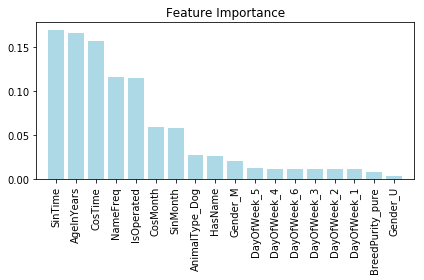

[ 5  2  6 17  1  4  3  7  0]


In [378]:
importances = rf_basic.feature_importances_
indices = np.argsort(importances)[::-1]
[expl_variables[x] for x in indices]

plot_feature_importance(importances, indices, len(expl_variables), np.array(expl_variables))
print indices[:9]

In [394]:
# plot roc-auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import label_binarize

y_valid_bin = label_binarize(y_valid, classes=[0,1,2,3,4])
roc_predictions = rf_basic.predict(X_valid)
roc_prob = rf_basic.predict_proba(X_valid)


In [401]:
# refer to https://plot.ly/scikit-learn/plot-roc/
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_valid_bin[:, i], roc_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

print roc_auc
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid_bin.ravel(), roc_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

{0: 0.88723002578145305, 1: 0.8076574877404753, 2: 0.85248636386807353, 3: 0.83300586303582591, 4: 0.89572742119152859}
{0: 0.88723002578145305, 1: 0.8076574877404753, 2: 0.85248636386807353, 3: 0.83300586303582591, 4: 0.89572742119152859, 'micro': 0.9231511277793949}


In [407]:
print y_valid_bin[:20, 0] 
print np.where(roc_prob[:20, 0] >= 0.5 ==

[0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0]
[False  True  True False False False False False  True  True False  True
 False  True  True  True False False False False]


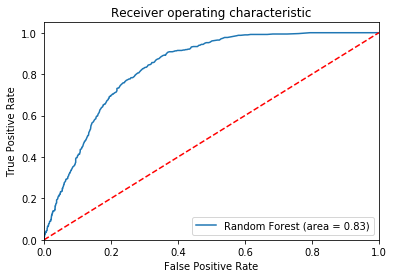

In [404]:
plt.figure()
plt.plot(fpr[3], tpr[3], label='Random Forest (area = %0.2f)' % roc_auc[3])
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [238]:
#from sklearn.svm import SVC
#from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV

# This dataset is way too high-dimensional. Better do PCA:
#pca = PCA(n_components=2)

# Maybe some original features where good, too?
minmax = MinMaxScaler()
selection = SelectKBest()

# Build estimator from PCA and Univariate selection:
#combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])
#combined_features = FeatureUnion([("univ_select", selection)])

# Use combined features to transform dataset:
#X_features = combined_features.fit(X_train, y_train).transform(X_train)

clf = LogisticRegression(random_state=1,C=1,solver='lbfgs')
#lr = LogisticRegression(penalty='l2', C=10**-1, random_state=0, multi_class='multinomial', solver='lbfgs')

# Do grid search over k, n_components and C:
pipeline = Pipeline([("minmax", minmax ), ("kbest", selection), ("clf", clf)])

param_grid = dict(#features__pca__n_components=[1, 2, 3],    
                  kbest__k=range(1, len(expl_variables)),
                  clf__C=[0.1,1,10],
                  #clf__class_weight=[None,'balanced'])
                  clf__multi_class=['ovr','multinomial'])
                  #lr__solver=['sag', 'lbfgs'])                                    
                  
                    
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_log_loss')
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

/usr/local/lib/python2.7/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [17] are constant.
  UserWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Pipeline(memory=None,
     steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))), ('kbest', SelectKBest(k=13, score_func=<function f_classif at 0x7ff897deeed8>)), ('clf', LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=1, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])
-0.889914438733


In [239]:
valid_prediction = grid_search.predict(X_valid)
valid_prediction_prob = grid_search.predict_proba(X_valid)
print(classification_report(y_valid, valid_prediction, target_names=le.classes_))
log_loss(y_valid, valid_prediction_prob)

                 precision    recall  f1-score   support

       Adoption       0.62      0.87      0.72      1077
           Died       0.00      0.00      0.00        20
     Euthanasia       0.65      0.08      0.15       156
Return_to_owner       0.51      0.32      0.39       479
       Transfer       0.73      0.64      0.68       939

    avg / total       0.63      0.64      0.61      2671



0.89229330135209395

In [240]:
# use feature selection from RandomForest and logistic classifier
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.ensemble import RandomForestClassifier

minmax = MinMaxScaler()
rf = RandomForestClassifier(random_state=2, n_estimators=500)
lr2 = LogisticRegression(multi_class='multinomial')
feat_selection = SelectFromModel(rf)

pipeline = Pipeline([
 #   ('minmax', minmax),
    ('feature_selection', feat_selection),
    ('lr', lr2)
])
param_grid = dict(feature_selection__estimator__n_estimators=[100, 300, 500],
                  feature_selection__estimator__max_features=['log2', 'sqrt'],
                  lr__multi_class=['ovr','multinomial'],
                  lr__solver=['lbfgs'])
                  #lr__C=[0.1, 1, 10])
                  
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_log_loss')
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])
-0.963638008668


In [241]:
select_indices = grid_search.best_estimator_.named_steps['feature_selection'].transform(
    np.arange(len(expl_variables)).reshape(1, -1) 
).ravel()
print select_indices

#expl_variables[select_indices.ravel()]
#expl_variables[0:4]

print [expl_variables[i] for i in select_indices]

valid_prediction = grid_search.predict(X_valid)
valid_prediction_prob = grid_search.predict_proba(X_valid)
print(classification_report(y_valid, valid_prediction, target_names=le.classes_))
log_loss(y_valid, valid_prediction_prob)

grid_search.best_estimator_.named_steps['lr'].coef_


[1 2 3 4 5 6]
['IsOperated', 'AgeInYears', 'SinMonth', 'CosMonth', 'SinTime', 'CosTime']
                 precision    recall  f1-score   support

       Adoption       0.60      0.90      0.72      1077
           Died       0.00      0.00      0.00        20
     Euthanasia       0.46      0.07      0.12       156
Return_to_owner       0.42      0.21      0.28       479
       Transfer       0.74      0.62      0.68       939

    avg / total       0.60      0.62      0.58      2671



array([[ 3.04638346, -3.59609482, -0.13591448, -0.05834192, -1.08052202,
         0.56025191],
       [-1.66377343, -0.42480868, -0.21725677, -0.17675596,  1.87391839,
         0.30129763],
       [-1.3690201 ,  3.16779376,  0.08424187,  0.05278409,  0.06274163,
        -0.44899452],
       [ 0.82191588,  2.33239537,  0.28001946,  0.17568628, -1.17592934,
        -0.12912749],
       [-0.83550582, -1.47928563, -0.01109009,  0.00662751,  0.31979134,
        -0.28342753]])

# ScratchPad

In [117]:
dt = datetime.now()

print dt.weekday()
print dt.month
print dt.hour
print dt.hour + round(dt.minute/60.0)
print dt.minute
print dt.second
seconds_in_day = 24*60*60
dt = (dt.hour * 3600) + (dt.minute * 60) + dt.second
# Monday = 0; Tue = 1; Wed = 2; Thurs = 3; Fri = 4; Sat = 5; Sun = 6


1
1
12
12.0
26
10


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def rand_times(n):
    """Generate n rows of random 24-hour times (seconds past midnight)"""
    rand_seconds = np.random.randint(0, 24*60*60, n)
    return pd.DataFrame(data=dict(seconds=rand_seconds))

n_rows = 1000

df = rand_times(n_rows)
# sort for the sake of graphing
df = df.sort_values('seconds').reset_index(drop=True)
df.head()

#df.seconds.plot();

seconds_in_day = 24*60*60

df['sin_time'] = np.sin(2*np.pi*df.seconds/seconds_in_day)
df['cos_time'] = np.cos(2*np.pi*df.seconds/seconds_in_day)

#df = df.drop(['seconds'], axis=1)

#df.sample(50).plot.scatter('sin_time','cos_time').set_aspect('equal');

df.sin_time.plot();
print df.iloc[500,:]
df.cos_time.plot();